In [29]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from utils import nc_to_pd, prepare_simulated

# from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcess

from sklearn import gaussian_process


from sklearn.gaussian_process.kernels import RBF, DotProduct, ExpSineSquared

In [17]:
if sys.platform == 'win32':
    save_folder = "F:/Google Drive/Dropbox_Backup/Post Study/Industrial/Courses/DTU Advanced Machine Learning, 2020/gaussian_solar_project/data/"
else:
    save_folder = "/home/local/DAC/ahn/Documents/dcwis.solar/dcwis/solar/reports/dtu/"

In [18]:
meuro_sim = pd.read_csv(save_folder + 'meuro_simulated.csv', skiprows=[0,1,2])
neuhardenberg_sim = pd.read_csv(save_folder + 'neuhardenberg_simulated.csv', skiprows=[0,1,2])
templin_sim = pd.read_csv(save_folder + 'templin_simulated.csv', skiprows=[0,1,2])

In [19]:
meuro_irradiance = pd.read_csv(save_folder + 'irradiance_meuro_data.csv').set_index('time')
meuro_irradiance.index = pd.to_datetime(meuro_irradiance.index, utc=True)

neuhardenberg_irradiance = pd.read_csv(save_folder + 'irradiance_neuhardenberg_data.csv').set_index('time')
neuhardenberg_irradiance.index = pd.to_datetime(neuhardenberg_irradiance.index, utc=True)

templin_irradiance = pd.read_csv(save_folder + 'irradiance_templin_data.csv').set_index('time')
templin_irradiance.index = pd.to_datetime(templin_irradiance.index, utc=True)

In [20]:
# prepare our simulated dataframes
meuro_sim = prepare_simulated(meuro_sim, meuro_irradiance.index)
neuhardenberg_sim = prepare_simulated(neuhardenberg_sim, neuhardenberg_irradiance.index)
templin_sim = prepare_simulated(templin_sim, templin_irradiance.index)

In [72]:
import sklearn
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, ExpSineSquared

In [73]:
x = meuro_irradiance.values.ravel()
y = meuro_sim.values.ravel()

x_test = neuhardenberg_irradiance.values.ravel()
y_test = neuhardenberg_sim.values.ravel()

xpts = np.linspace(0, 500, num=10000)

In [74]:
rbf =  ConstantKernel(2) *RBF(length_scale=0.5) * ExpSineSquared(length_scale=2, periodicity=3)  
# gp = gaussian_process.GaussianProcessRegressor()
gp = GaussianProcessRegressor(kernel=rbf, alpha=0.4**2, normalize_y=True)
# gp = gaussian_process.GaussianProcessRegressor()
gp.fit(x.reshape(-1, 1), y)

predictedY, sigma = gp.predict(x_test.reshape(-1, 1), return_std=True)

# results = testSet.copy()
# results['predictedY'] = predictedY
# results['sigma'] = sigma

print("Train score R2:{}".format(gp.score(x.reshape(-1, 1), y)))
print("Test score R2:{}".format(sklearn.metrics.r2_score(y_test, predictedY)))



Train score R2:0.9239222382475987
Test score R2:0.9040301654227955


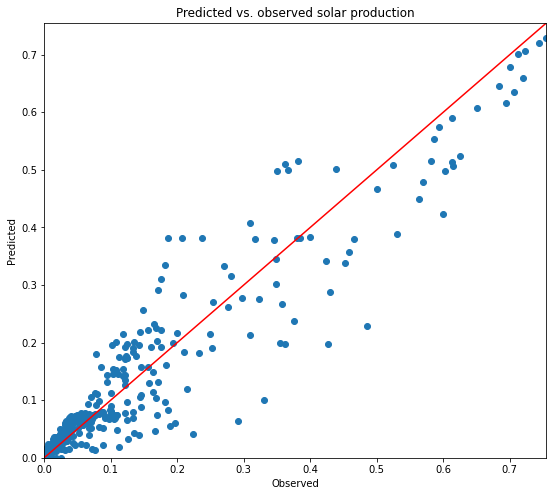

In [75]:
plt.figure(figsize = (9,8))
plt.scatter(y_test, predictedY)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
plt.xlim([min(y_test), max(y_test)])
plt.ylim([min(y_test), max(y_test)])
plt.title('Predicted vs. observed solar production')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.show()

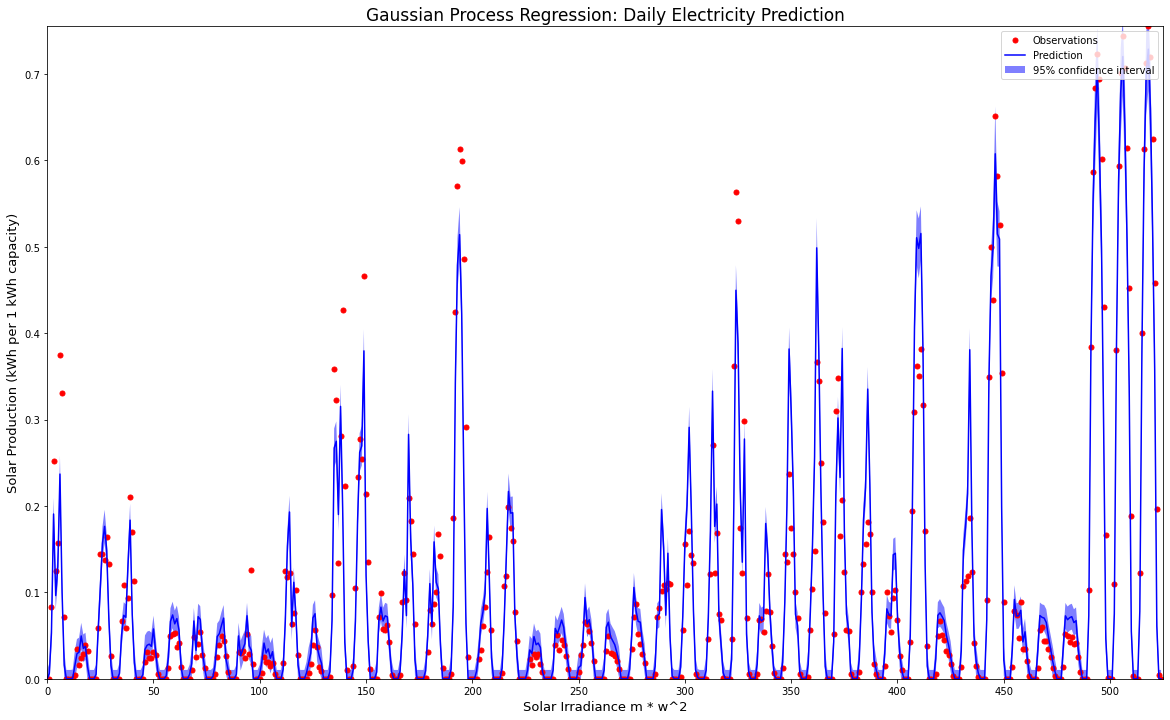

In [223]:
def plotGP(testY, predictedY, sigma):
    fig = plt.figure(figsize = (20,12))
    plt.plot(testY, 'r.', markersize=10, label=u'Observations')
    plt.plot(predictedY, 'b-', label=u'Prediction')
    x = range(len(testY))
    plt.fill(np.concatenate([x, x[::-1]]), np.concatenate([predictedY - 1.9600 * sigma, (predictedY + 1.9600 * sigma)[::-1]]),
             alpha=.5, fc='b', ec='None', label='95% confidence interval')

plotGP(y_test, predictedY, sigma)

plt.ylabel('Solar Production (kWh per 1 kWh capacity)', fontsize = 13)
plt.xlabel('Solar Irradiance m * w^2', fontsize = 13)
plt.title('Gaussian Process Regression: Daily Electricity Prediction', fontsize = 17)
plt.legend(loc='upper right')
plt.xlim([0, len(y_test)])
plt.ylim([min(y_test), max(y_test)])

# xTickLabels = pd.DataFrame(data = subset.index[np.arange(0,len(subset.index),10)], columns=['datetime'])
# xTickLabels['date'] = xTickLabels['datetime'].apply(lambda x: x.strftime('%Y-%m-%d'))
ax = plt.gca()
ax.set_xticks(np.arange(0, len(x_test), 50))
plt.show()

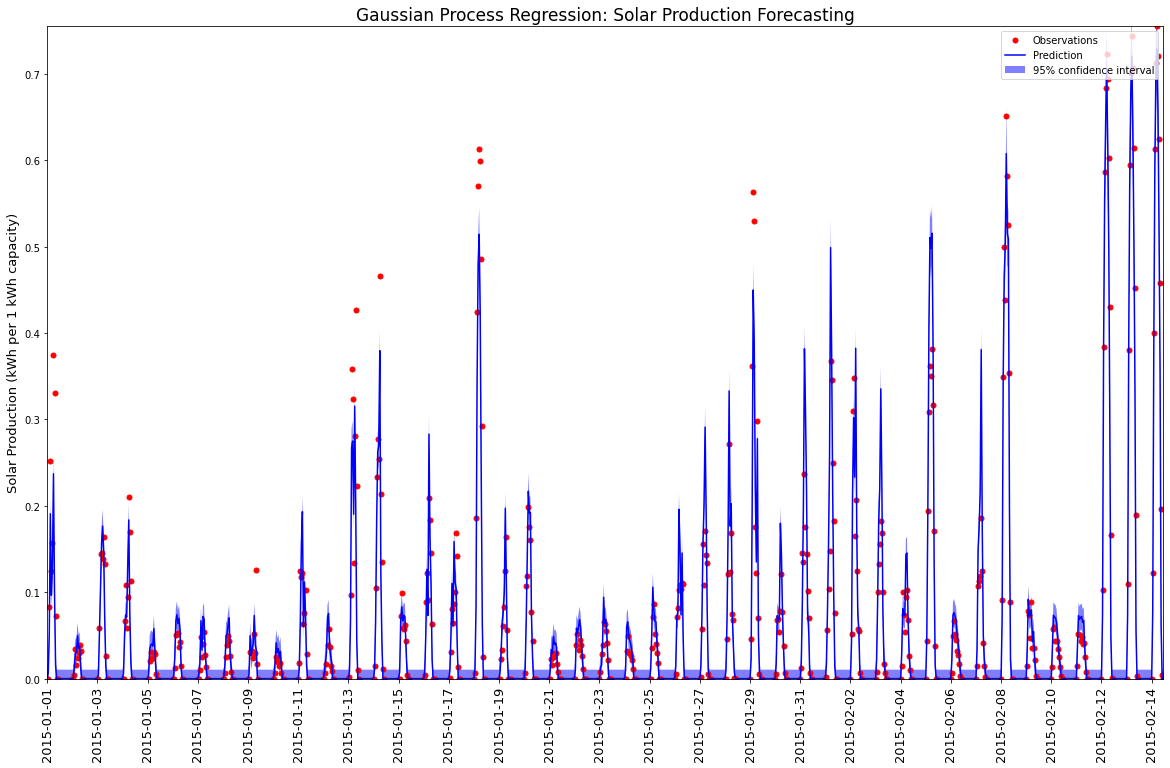

In [225]:
def plotGP(testY, predictedY, sigma):
    fig = plt.figure(figsize = (20,12))
    plt.plot_date(neuhardenberg_sim.index, testY, 'r.', markersize=10, label=u'Observations')
    plt.plot_date(neuhardenberg_sim.index, predictedY, 'b-', label=u'Prediction')
    x = range(len(testY))
    plt.fill(np.concatenate([neuhardenberg_sim.index, neuhardenberg_sim.index[::-1]]), np.concatenate([predictedY - 1.9600 * sigma, (predictedY + 1.9600 * sigma)[::-1]]),
          alpha=.5, fc='b', ec='None', label='95% confidence interval')
#     plt.fill(np.concatenate([x, x[::-1]]), np.concatenate([predictedY - 1.9600 * sigma, (predictedY + 1.9600 * sigma)[::-1]]),
#              alpha=.5, fc='b', ec='None', label='95% confidence interval')

plotGP(y_test, predictedY, sigma)

plt.ylabel('Solar Production (kWh per 1 kWh capacity)', fontsize = 13)
plt.title('Gaussian Process Regression: Solar Production Forecasting', fontsize = 17)
plt.legend(loc='upper right')
plt.xlim([neuhardenberg_sim.index[0], neuhardenberg_sim.index[-1]])
plt.ylim([min(y_test), max(y_test)])


datetimes = neuhardenberg_sim.index


xTickLabels = pd.DataFrame(datetimes, columns=['time'])
xTickLabels['date'] = xTickLabels['time'].apply(lambda x: x.strftime('%Y-%m-%d'))

ax = plt.gca()

dates, indices = np.unique(datetimes.date, return_index=True)


ax.set_xticks(neuhardenberg_sim.index[indices[::2]])
ax.set_xticklabels(labels = xTickLabels['date'].iloc[indices[::2]], fontsize = 13, rotation = 90)


plt.show()

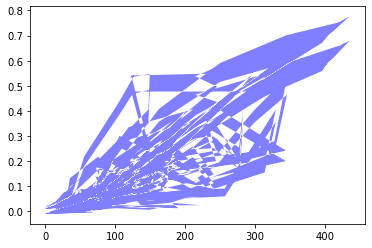

In [227]:
    plt.fill(np.concatenate([x, x[::-1]]), np.concatenate([predictedY - 1.9600 * sigma, (predictedY + 1.9600 * sigma)[::-1]]),
             alpha=.5, fc='b', ec='None', label='95% confidence interval')

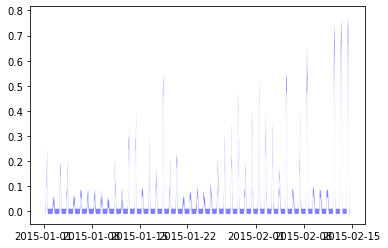

In [228]:
    plt.fill(np.concatenate([neuhardenberg_sim.index, neuhardenberg_sim.index[::-1]]), np.concatenate([predictedY - 1.9600 * sigma, (predictedY + 1.9600 * sigma)[::-1]]),
          alpha=.5, fc='b', ec='None', label='95% confidence interval')

In [230]:
np.concatenate([neuhardenberg_sim.index, neuhardenberg_sim.index[::-1]])

array([Timestamp('2015-01-01 06:00:00+0000', tz='UTC'),
       Timestamp('2015-01-01 07:00:00+0000', tz='UTC'),
       Timestamp('2015-01-01 08:00:00+0000', tz='UTC'), ...,
       Timestamp('2015-01-01 08:00:00+0000', tz='UTC'),
       Timestamp('2015-01-01 07:00:00+0000', tz='UTC'),
       Timestamp('2015-01-01 06:00:00+0000', tz='UTC')], dtype=object)

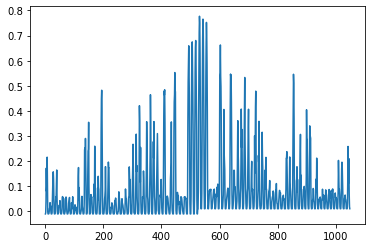

In [233]:
plt.plot(np.concatenate([predictedY - 1.9600 * sigma, (predictedY + 1.9600 * sigma)[::-1]]))

In [235]:
def squared_exponential_kernel(x, y, lengthscale, variance):
    '''
    Function that computes the covariance matrix using a squared-exponential kernel
    '''
    # pair-wise distances, size: NxM
    sqdist = cdist(x.reshape((-1, 1)), y.reshape((-1, 1)), 'sqeuclidean')
    # compute the kernel
    cov_matrix = variance * np.exp(-0.5 * sqdist * (1/lengthscale**2))  # NxM
    return cov_matrix


def fit_predictive_GP(X, y, Xtest, lengthscale, kernel_variance, noise_variance):
    '''
    Function that fit the Gaussian Process. It returns the predictive mean function and
    the predictive covariance function. It follows step by step the algorithm on the lecture
    notes
    '''
    X = np.array(X).reshape(-1, 1)
    y = np.array(y)
    K = squared_exponential_kernel(X, X, lengthscale, kernel_variance)
    L = np.linalg.cholesky(K + noise_variance * np.eye(len(X)))

    # compute the mean at our test points.
    Ks = squared_exponential_kernel(X, Xtest, lengthscale, kernel_variance)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))  #
    mu = Ks.T @ alpha

    v = np.linalg.solve(L, Ks)
    # compute the variance at our test points.
    Kss = squared_exponential_kernel(Xtest, Xtest, lengthscale, kernel_variance)
    covariance = Kss - (v.T @ v)
    
    return mu, covariance


# Here PyTorch is used to define the optimization function, with an ADAM optimizer
# This is likely not a very efficient nor pretty way to do this.

def optimize_GP_hyperparams(Xtrain, ytrain, optimization_steps, learning_rate, mean_prior, prior_std):
    '''
    Methods that run the optimization of the hyperparams of our GP. We will use
    Gradient Descent because it takes to much time to run grid search at each step
    of bayesian optimization. We use a different definition of the kernel to make the
    optimization more stable

    :param X: training set points
    :param y: training targets
    :return: values for lengthscale, output_var, noise_var that maximize the log-likelihood
    '''
    
    # we are re-defining the kernel because we need it in PyTorch
    def squared_exponential_kernel_torch(x, y, _lambda, variance):
        x = x.squeeze(1).expand(x.size(0), y.size(0))
        y = y.squeeze(0).expand(x.size(0), y.size(0))
        sqdist = torch.pow(x - y, 2)
        k = variance * torch.exp(-0.5 * sqdist * (1/_lambda**2))  # NxM
        return k

    X = np.array(Xtrain).reshape(-1,1)
    y = np.array(ytrain).reshape(-1,1)
    N = len(X)

    # tranform our training set in Tensor
    Xtrain_tensor = torch.from_numpy(X).float()
    ytrain_tensor = torch.from_numpy(y ).float()
    # we should define our hyperparameters as torch parameters where we keep track of
    # the operations to get hte gradients from them
    _lambda = nn.Parameter(torch.tensor(1.), requires_grad=True)
    output_variance = nn.Parameter(torch.tensor(1.), requires_grad=True)
    noise_variance = nn.Parameter(torch.tensor(.5), requires_grad=True)

    # we use Adam as optimizer
    optim = torch.optim.Adam([_lambda, output_variance, noise_variance], lr=learning_rate)

    # optimization loop using the log-likelihood that involves the cholesky decomposition 
    nlls = []
    lambdas = []
    output_variances = []
    noise_variances = []
    iterations = optimization_steps
    for i in range(iterations):
        assert noise_variance >= 0, f"ouch! {i, noise_variance}"
        optim.zero_grad()
        K = squared_exponential_kernel_torch(Xtrain_tensor, Xtrain_tensor, _lambda,
                                                output_variance) + noise_variance * torch.eye(N)
        
        L = torch.cholesky(K)
        _alpha_temp, _ = torch.solve(ytrain_tensor, L)
        _alpha, _ = torch.solve(_alpha_temp, L.t())
        nll = N / 2 * torch.log(torch.tensor(2 * np.pi)) + 0.5 * torch.matmul(ytrain_tensor.transpose(0, 1),
                                                                              _alpha) + torch.sum(torch.log(torch.diag(L)))

        # we have to add the log-likelihood of the prior
        norm = distributions.Normal(loc=mean_prior, scale=prior_std)
        prior_negloglike =  torch.log(_lambda) - torch.log(torch.exp(norm.log_prob(_lambda)))

        nll += 0.9 * prior_negloglike
        nll.backward()

        nlls.append(nll.item())
        lambdas.append(_lambda.item())
        output_variances.append(output_variance.item())
        noise_variances.append(noise_variance.item())
        optim.step()

        # projected in the constraints (lengthscale and output variance should be positive)
        for p in [_lambda, output_variance]:
            p.data.clamp_(min=0.0000001)

        noise_variance.data.clamp_(min=1e-5, max= 0.05)

        
    return _lambda.item(), output_variance.item(), noise_variance.item()

Xtrain shape (525, 1)
ytrain shape (525,)


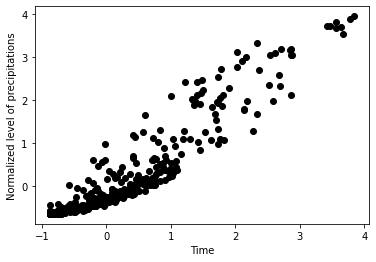

NameError: name 'torch' is not defined

In [237]:
## We load the data and use only some of them.
## We subsample the data, which gives us N pairs of (x, y)
M = 1000
# data = loadmat('weather_dataset.mat')
# sampling part 
# Xtrain = np.arange(0, M, 20)
# ytrain = data['TMPMAX'][Xtrain]

Xtrain = meuro_irradiance.values.ravel()
ytrain = meuro_sim.values.ravel()
N = len(ytrain)
Xtrain = Xtrain.reshape(-1,1)

Xtest = neuhardenberg_irradiance.values.ravel()
y_test = neuhardenberg_sim.values.ravel()


# gp.fit(x.reshape(-1, 1), y)

# predictedY, sigma = gp.predict(x_test.reshape(-1, 1), return_std=True)


# print dataset information
print('Xtrain shape', Xtrain.shape)
print('ytrain shape', ytrain.shape)

# also in this case we standardize the data to have zero mean and unit variance
Xtrain = (Xtrain - np.mean(Xtrain)) / np.std(Xtrain)
ytrain = (ytrain - np.mean(ytrain)) / np.std(ytrain)

# and plot it
plt.plot(Xtrain, ytrain, 'o', color='black')
plt.ylabel('Normalized level of precipitations')
plt.xlabel('Time')
plt.show()

# we shall also define the test set, that is the range of XTest points we want to 
# use to compute the mean and the variance
# Xtest = np.linspace(-2, 2, M).reshape(-1,1)

## we have to define the mena and variance of the log-normal distribution for the lengthscale prior 
prior_mean = -1.5
prior_std = 0.6

lengthscale, output_var, noise_var = optimize_GP_hyperparams(Xtrain, ytrain, 500, 5e-3, prior_mean, prior_std)
print('Optimized parameters:', lengthscale, output_var, noise_var)

# we can fit the GP that use the hyperparameters found above
mu, covariance = fit_predictive_GP(Xtrain, ytrain, Xtest, lengthscale, output_var, noise_var)
std = np.sqrt(np.diag(covariance))
plt.plot(Xtrain, ytrain, 'ro', label='Training points')
plt.gca().fill_between(Xtest.flat, mu.reshape(-1) - 2 * std, mu.reshape(-1) + 2 * std,  color='lightblue', alpha=0.5, label=r"$\mu$")
plt.plot(Xtest, mu, 'blue', label=r"$2\sigma$")
plt.legend()
plt.show() 
